# 🧩 Módulo 3.3: Algoritmos de Clustering
### Curso: **Machine Learning con Python** (IFCD093PO)
**Duración estimada:** 8 horas

---

## 🎯 Objetivos del Módulo

Has aprendido qué es el clustering y cómo medir su éxito. Ahora es el momento de sumergirse en los motores que lo hacen posible. En este módulo, explorarás tres de los algoritmos de clustering más fundamentales y utilizados en la industria, cada uno con sus propias fortalezas y debilidades.

Al finalizar, serás capaz de:

- ✅ Implementar y entender el funcionamiento interno de **K-Means**, el algoritmo de clustering más popular.
- ✅ Aplicar el **Clustering Jerárquico Aglomerativo** para crear dendrogramas y entender las relaciones jerárquicas en tus datos.
- ✅ Utilizar **DBSCAN**, un potente algoritmo basado en densidad, para encontrar clústeres de formas arbitrarias y aislar el ruido.
- ✅ Elegir el algoritmo de clustering más adecuado para diferentes tipos de datos y problemas.
- ✅ Visualizar y comparar los resultados de los diferentes algoritmos.

**¡Prepárate para agrupar datos como un profesional y descubrir las estructuras ocultas con las herramientas adecuadas!**

---

## 📚 Tabla de Contenidos

1. [Preparación y Datasets de Prueba](#1-preparacion)
2. [K-Means: El Rey de los Clústeres](#2-kmeans)
   - [Intuición y Algoritmo](#2.1-intuicion-kmeans)
   - [Implementación con Scikit-Learn](#2.2-implementacion-kmeans)
   - [Ventajas y Desventajas](#2.3-ventajas-kmeans)
3. [Clustering Jerárquico: El Árbol de Grupos](#3-jerarquico)
   - [Intuición: Aglomerativo vs. Divisivo](#3.1-intuicion-jerarquico)
   - [El Dendrograma: Visualizando la Jerarquía](#3.2-dendrograma)
   - [Implementación y Corte del Dendrograma](#3.3-implementacion-jerarquico)
   - [Ventajas y Desventajas](#3.4-ventajas-jerarquico)
4. [DBSCAN: Clustering Basado en Densidad](#4-dbscan)
   - [Intuición: Puntos Núcleo, Frontera y Ruido](#4.1-intuicion-dbscan)
   - [Implementación y Elección de Hiperparámetros](#4.2-implementacion-dbscan)
   - [Ventajas y Desventajas](#4.3-ventajas-dbscan)
5. [Comparativa de Algoritmos](#5-comparativa)
6. [Ejercicios Prácticos](#6-ejercicios)
7. [Resumen y Próximos Pasos](#7-resumen)

---

## 🧪 1. Preparación y Datasets de Prueba <a id='1-preparacion'></a>

Para comparar los algoritmos, usaremos varios datasets sintéticos que pongan de manifiesto sus fortalezas y debilidades.

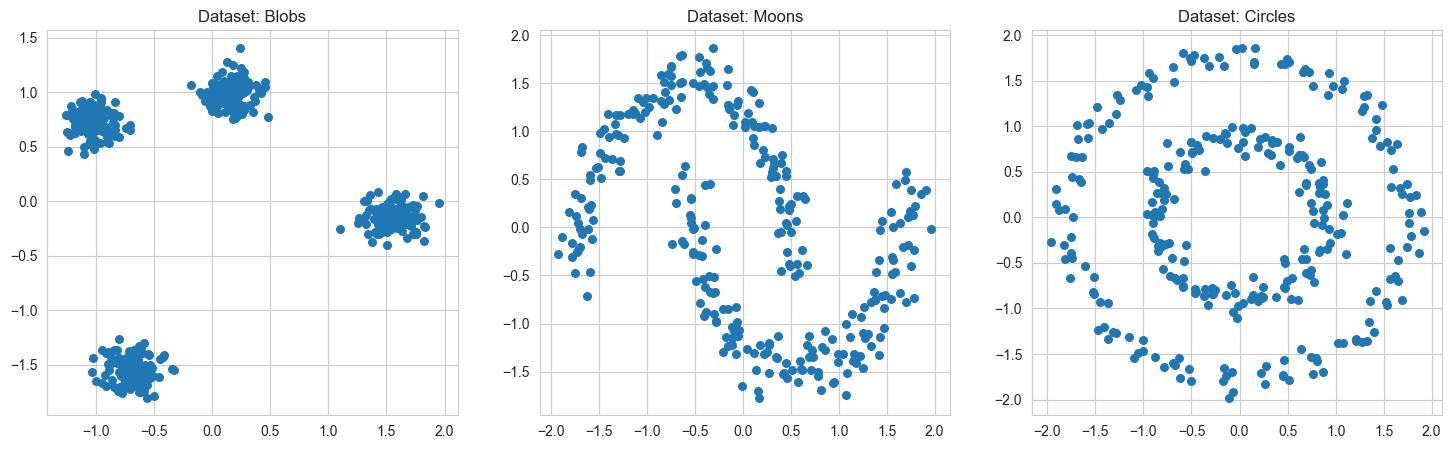

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

sns.set_style('whitegrid')

# --- Datasets ---

# 1. Blobs: Grupos bien separados y esféricos (ideal para K-Means)
X_blobs, y_blobs = make_blobs(n_samples=500, centers=4, cluster_std=0.7, random_state=42)
X_blobs = StandardScaler().fit_transform(X_blobs)

# 2. Moons: Dos medias lunas entrelazadas (difícil para K-Means)
X_moons, y_moons = make_moons(n_samples=300, noise=0.08, random_state=42)
X_moons = StandardScaler().fit_transform(X_moons)

# 3. Circles: Círculos concéntricos (imposible para K-Means)
X_circles, y_circles = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)
X_circles = StandardScaler().fit_transform(X_circles)

datasets = {
    "Blobs": X_blobs,
    "Moons": X_moons,
    "Circles": X_circles
}

# --- Función de visualización ---

def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    # El -1 es para el ruido en DBSCAN, lo pintamos de negro
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1] # Negro para el ruido
        
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Visualizar los datasets originales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, X) in enumerate(datasets.items()):
    axes[i].scatter(X[:, 0], X[:, 1], s=30)
    axes[i].set_title(f'Dataset: {name}')
plt.show()

---

## 👑 2. K-Means: El Rey de los Clústeres <a id='2-kmeans'></a>

K-Means es, con diferencia, el algoritmo de clustering más conocido y utilizado. Es rápido, escalable y fácil de interpretar.

### 2.1 Intuición y Algoritmo <a id='2.1-intuicion-kmeans'></a>

El algoritmo K-Means agrupa los datos intentando separar las muestras en `k` grupos de igual varianza, minimizando un criterio conocido como **inercia** o *suma de cuadrados dentro del clúster*.

El algoritmo funciona de forma iterativa:

*ALGORITMO K-MEANS(Datos, K)*

#### **Entrada:**
- Datos: Un conjunto de N puntos de datos (por ejemplo, P1, P2, ..., PN)
- K: El número deseado de clústeres

#### **Salida:**
- K Clústeres, donde cada clúster contiene un conjunto de puntos de datos y un centroide.

**PASO 1: Inicialización**
    1.1 Seleccionar K puntos aleatorios de 'Datos' como los centroides iniciales (C1, C2, ..., CK).
        // Alternativamente, se pueden seleccionar puntos aleatorios dentro del rango de los datos.

**PASO 2: Iterar hasta la convergencia** (o hasta un número máximo de iteraciones)
    LOOP hasta que no haya cambios significativos en los clústeres o centroides:

    PASO 2.1: Asignación de Puntos a Clústeres (Paso de Asignación)
        // Crear una lista vacía para cada clúster para almacenar los puntos asignados.
        Para cada centroide Ci en (C1, ..., CK):
            Inicializar Clúster[i] = una lista vacía

        Para cada punto de datos Pj en 'Datos':
            Calcular la distancia de Pj a cada centroide Ci.
            Encontrar el centroide Cm al que Pj está más cerca (distancia mínima).
            Asignar Pj al Clúster[m].

    PASO 2.2: Actualización de Centroides (Paso de Actualización)
        // Calcular la nueva posición de cada centroide como la media de todos los puntos asignados a su clúster.
        Para cada Clúster[i]:
            Si Clúster[i] no está vacío:
                Calcular el nuevo centroide Ci_nuevo como la media de todos los puntos en Clúster[i].
            Si Clúster[i] está vacío:
                // Esto puede ocurrir si un centroide se queda sin puntos.
                // Una estrategia común es reubicarlo aleatoriamente o eliminarlo.
                // Para simplificar, asumiremos que los clústeres no se quedan vacíos aquí.

            Actualizar Ci = Ci_nuevo.

    // Comprobar la condición de convergencia:
    // Si los centroides no han cambiado su posición (o el cambio es menor que un umbral pequeño)
    // O si los puntos asignados a cada clúster no han cambiado desde la última iteración.
    // O si se ha alcanzado el número máximo de iteraciones permitido.
    // ENTONCES, SALIR DEL BUCLE.

*FIN DEL ALGORITMO*

![K-Means Animation](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/K-means_convergence.gif/220px-K-means_convergence.gif)

- **Distancia:** La distancia más común utilizada es la distancia euclidiana, pero se pueden usar otras métricas de distancia.

- **Convergencia:** La condición de parada es crucial. El algoritmo se detiene cuando los clústeres se han estabilizado (los puntos ya no cambian de clúster) o los centroides ya no se mueven. También se suele establecer un número máximo de iteraciones para evitar bucles infinitos en casos raros o para limitar el tiempo de cómputo.

- **K inicial:** La elección de K es un factor importante. Métodos como el "método del codo" o el coeficiente de silueta pueden ayudar a determinar un K óptimo.

- **Inicialización de centroides:** La inicialización aleatoria puede llevar a diferentes resultados en cada ejecución. Técnicas como K-means++ buscan una mejor inicialización para evitar malos óptimos locales.

### Visualización interactiva de K-means

Para explorar la visualización interactiva de k-means, haz clic en el siguiente enlace. Se abrirá el archivo HTML en una nueva pestaña de tu navegador por defecto:

[🔗 Abrir visualización interactiva de k-means](dbscan/kmeans.html)

In [ ]:
print("--- Aplicando K-Means a los datasets ---")

# K-Means en Blobs (k=4)
kmeans_blobs = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_blobs = kmeans_blobs.fit_predict(X_blobs)
plot_clusters(X_blobs, labels_blobs, 'K-Means en Dataset Blobs')
print(f"Silhouette Score (Blobs): {silhouette_score(X_blobs, labels_blobs):.3f}")

# K-Means en Moons (k=2)
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_moons = kmeans_moons.fit_predict(X_moons)
plot_clusters(X_moons, labels_moons, 'K-Means en Dataset Moons')
print(f"Silhouette Score (Moons): {silhouette_score(X_moons, labels_moons):.3f}")

# K-Means en Circles (k=2)
kmeans_circles = KMeans(n_clusters=2, random_state=42, n_init='auto')
labels_circles = kmeans_circles.fit_predict(X_circles)
plot_clusters(X_circles, labels_circles, 'K-Means en Dataset Circles')
print(f"Silhouette Score (Circles): {silhouette_score(X_circles, labels_circles):.3f}")

**Análisis de Resultados:**

- **Blobs**: ¡Perfecto! K-Means funciona de maravilla cuando los clústeres son esféricos y están bien separados. El Silhouette Score es muy alto.
- **Moons**: Falla estrepitosamente. K-Means traza una línea recta para separar los grupos, ya que asume que los clústeres son convexos (como esferas). No puede capturar la estructura de las lunas.
- **Circles**: Falla de nuevo por la misma razón. No puede entender que un clúster está "dentro" de otro.

### 2.3 Ventajas y Desventajas de K-Means <a id='2.3-ventajas-kmeans'></a>

**Ventajas:**

✅ **Rápido y Escalable**: Es uno de los algoritmos más rápidos, especialmente para grandes datasets.

✅ **Fácil de interpretar**: La idea de los centroides es muy intuitiva.

✅ **Convergencia garantizada**: Siempre converge (aunque no necesariamente a la solución óptima global).

**Desventajas:**

❌ **Necesita saber `k` de antemano**: Debes especificar el número de clústeres, lo cual no siempre es fácil (aunque tenemos el método del codo y la silueta para ayudar).

❌ **Hay que aplicar normalización**: Al conjunto de datos

❌ **No debe utilizarse con datos categórizados**: No usar a los que se le aplican *one-hot encoding*. Por el contrario, deben tratar de codificarse estas características como *multiple binary*.

❌ **Sensible a la inicialización**: Diferentes ejecuciones pueden dar resultados diferentes. `n_init` en Scikit-Learn ayuda a mitigar esto ejecutándolo varias veces.

❌ **Asume clústeres esféricos**: Falla con clústeres de formas no convexas o tamaños muy diferentes.

❌ **Sensible a outliers**: Los puntos atípicos pueden arrastrar los centroides.

---

## 🌳 3. Clustering Jerárquico: El Árbol de Grupos <a id='3-jerarquico'></a>

Este método construye una jerarquía de clústeres, ya sea de forma aglomerativa (de abajo hacia arriba) o divisiva (de arriba hacia abajo). Nos centraremos en el **aglomerativo**, que es el más común.

### 3.1 Intuición: Aglomerativo vs. Divisivo <a id='3.1-intuicion-jerarquico'></a>

**Clustering Jerárquico Aglomerativo (AGNES):**

- Imagina que empiezas con cada punto como un grupo separado.
- En cada paso, buscas los dos grupos más cercanos y los unes en uno solo.
- Repites este proceso hasta que todos los puntos están juntos en un único grupo grande.

**¿Cómo decides qué grupos están “más cerca”?**  
Eso depende del **criterio de enlace (linkage)**:

- **`ward`**: Une los grupos que, al fusionarse, hacen que la “variedad” dentro de los grupos sea la menor posible. Es el más usado.
- **`complete`**: Mira la distancia más lejana entre los puntos de dos grupos y une los que tienen la menor de esas distancias máximas.
- **`average`**: Calcula la distancia promedio entre todos los puntos de dos grupos y une los que tienen la menor media.

**Resumen:**  
El método aglomerativo va juntando grupos poco a poco, siempre eligiendo los más cercanos según la forma de medir la distancia entre ellos.

### 3.2 El Dendrograma: Visualizando la Jerarquía <a id='3.2-dendrograma'></a>

La principal ventaja del clustering jerárquico es que todo el proceso de fusión se puede visualizar con un **dendrograma**. Este diagrama de árbol muestra cómo se fusionan los clústeres en cada paso.

La altura de las uniones en el dendrograma representa la distancia a la que se fusionaron los clústeres. Las líneas verticales más largas indican que se están fusionando clústeres que estaban muy separados, lo que sugiere un buen punto de corte.

In [ ]:
def plot_dendrogram(X, title):
    plt.figure(figsize=(12, 7))
    plt.title(title)
    # Usamos el método 'ward' que minimiza la varianza
    dend = sch.dendrogram(sch.linkage(X, method='ward'))
    plt.xlabel("Puntos de datos (o clústeres)")
    plt.ylabel("Distancia (Ward)")
    plt.show()

print("--- Dendrograma para el Dataset Blobs ---")
plot_dendrogram(X_blobs, "Dendrograma para Blobs")

print("--- Dendrograma para el Dataset Moons ---")
plot_dendrogram(X_moons, "Dendrograma para Moons")

print("--- Dendrograma para el Dataset Circles ---")
plot_dendrogram(X_circles, "Dendrograma para Circles")

**Análisis de los Dendrogramas:**

Para cada dataset, el dendrograma nos ayuda a visualizar cómo se agrupan los puntos y a decidir el número de clústeres adecuado:

- **Blobs:** Si cortamos a una altura de ~20, veremos 3 ramas principales, pero si bajamos un poco más, se distinguen claramente 4 ramas, que es el número real de grupos generados. El dendrograma muestra separaciones claras entre los grupos.

- **Moons:** El dendrograma no muestra saltos tan grandes en la altura de las fusiones, porque las dos medias lunas están entrelazadas. Aun así, si cortamos a una altura intermedia, suelen aparecer 2 ramas principales, que corresponden a las dos lunas. Sin embargo, la separación no es tan clara como en Blobs.

- **Circles:** Aquí el dendrograma muestra muchas fusiones a alturas similares, porque los círculos concéntricos no están tan bien separados según la distancia euclídea. Es más difícil elegir un punto de corte claro, pero si cortamos a una altura baja, suelen aparecer 2 ramas principales, que corresponden a los dos círculos.

**Consejo general:** Busca saltos grandes en la altura de las fusiones para elegir el número de clústeres. Si no hay saltos claros, el dendrograma te indica que la estructura de clústeres no es tan evidente para ese método o métrica de distancia.

In [ ]:
print("--- Aplicando Clustering Jerárquico a los datasets ---")

# Blobs: probamos con 3 y 4 clústeres para ver la relación con el corte del dendrograma
print("Blobs: n_clusters=3 (lo que sugiere el corte a altura ~20)")
agg_blobs_3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_blobs_3 = agg_blobs_3.fit_predict(X_blobs)
plot_clusters(X_blobs, labels_blobs_3, 'Clustering Jerárquico en Dataset Blobs (3 clústeres)')
print(f"Silhouette Score (Blobs, 3 clústeres): {silhouette_score(X_blobs, labels_blobs_3):.3f}")

print("Blobs: n_clusters=4 (el número real de grupos generados)")
agg_blobs_4 = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_blobs_4 = agg_blobs_4.fit_predict(X_blobs)
plot_clusters(X_blobs, labels_blobs_4, 'Clustering Jerárquico en Dataset Blobs (4 clústeres)')
print(f"Silhouette Score (Blobs, 4 clústeres): {silhouette_score(X_blobs, labels_blobs_4):.3f}")

# Moons y Circles igual que antes
print("Moons: n_clusters=2")
agg_moons = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_moons = agg_moons.fit_predict(X_moons)
plot_clusters(X_moons, labels_moons, 'Clustering Jerárquico en Dataset Moons')
print(f"Silhouette Score (Moons): {silhouette_score(X_moons, labels_moons):.3f}")

print("Circles: n_clusters=2")
agg_circles = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_circles = agg_circles.fit_predict(X_circles)
plot_clusters(X_circles, labels_circles, 'Clustering Jerárquico en Dataset Circles')
print(f"Silhouette Score (Circles): {silhouette_score(X_circles, labels_circles):.3f}")

# Comentario didáctico:
print("\nNota: El parámetro n_clusters debe elegirse observando el dendrograma. En este ejemplo, el corte a altura ~20 sugiere 3 clústeres, pero sabemos que el dataset Blobs fue generado con 4 grupos reales. ¡Compara los resultados!")

**Análisis de Resultados:**

- **Blobs**: Funciona perfectamente, al igual que K-Means.
- **Moons y Circles**: Falla de manera similar a K-Means. El método `ward` tiende a producir clústeres de tamaño similar y forma esférica, por lo que sufre de las mismas limitaciones que K-Means en estos casos. Otros métodos de `linkage` como `single` podrían funcionar mejor en estos casos, pero son más sensibles al ruido.

### 3.4 Ventajas y Desventajas del Clustering Jerárquico <a id='3.4-ventajas-jerarquico'></a>

**Ventajas:**

✅ **No necesita `k` de antemano**: Produce una jerarquía completa. Puedes elegir `k` después, cortando el dendrograma.

✅ **Resultados visualizables**: El dendrograma es una gran herramienta para entender la estructura de los datos.

✅ **Puede capturar estructuras de datos más complejas** (dependiendo del `linkage`).

**Desventajas:**

❌ **Computacionalmente costoso**: Tiene una complejidad de al menos O(n²), lo que lo hace inviable para datasets grandes.

❌ **Las decisiones de fusión son finales**: Una vez que se fusionan dos clústeres, nunca se pueden separar. Esto puede llevar a errores tempranos que se propagan.

❌ **Puede ser difícil interpretar el dendrograma** en datasets complejos.

---

## 4. DBSCAN: Clustering Basado en Densidad <a id='4-dbscan'></a>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un algoritmo completamente diferente. En lugar de agrupar por cercanía a un centroide, agrupa por la **densidad** de los puntos.

### 4.1 Intuición: Puntos Núcleo, Frontera y Ruido <a id='4.1-intuicion-dbscan'></a>

DBSCAN agrupa los datos buscando zonas donde los puntos están muy juntos (alta densidad) y separando estas zonas por regiones donde hay pocos puntos (baja densidad). Así, no necesita saber cuántos clústeres hay, sino que los "descubre" según la densidad de los datos.

Funciona correctamente con distribuciones no esféricas.

Para decidir qué puntos forman un clúster, DBSCAN usa dos parámetros clave:

- **`eps` (epsilon):** Es el radio o distancia máxima para considerar que dos puntos son vecinos.

- **`min_samples`:** Es el número mínimo de puntos (incluyendo el propio punto) que debe haber dentro del radio `eps` para que un punto sea considerado importante.

![min_samples](imagenes/caracteristicas.png)

Con esto, DBSCAN clasifica cada punto en tres tipos:

1. **Punto Núcleo:** Tiene al menos `min_samples` puntos (incluyéndose a sí mismo) dentro de su radio `eps`. Es decir, está en una zona densa.
2. **Punto Frontera:** No tiene suficientes vecinos para ser núcleo, pero está cerca (dentro de `eps`) de algún punto núcleo. Es como un "satélite" de una zona densa.
3. **Punto de Ruido (Outlier):** No cumple ninguna de las anteriores. Está aislado, lejos de zonas densas. DBSCAN lo etiqueta como `-1`.

**¿Cómo se forman los clústeres?**
- Un clúster se construye conectando puntos núcleo que están cerca unos de otros (a menos de `eps`). Todos los puntos frontera que estén cerca de algún núcleo se añaden al clúster más próximo.
- Los puntos de ruido quedan fuera de cualquier clúster.

**Resumen visual:**
- Imagina que pones un círculo de radio `eps` alrededor de cada punto. Si dentro de ese círculo hay suficientes puntos (`min_samples`), ese punto es un núcleo y puede "crear" un clúster. Los puntos frontera se pegan a los núcleos, y los que quedan solos son ruido.

### Visualización interactiva de DBSCAN

Para explorar la visualización interactiva de DBSCAN, haz clic en el siguiente enlace. Se abrirá el archivo HTML en una nueva pestaña de tu navegador por defecto:

[🔗 Abrir visualización interactiva de DBSCAN](dbscan/index.html)

--- Aplicando DBSCAN a los datasets ---


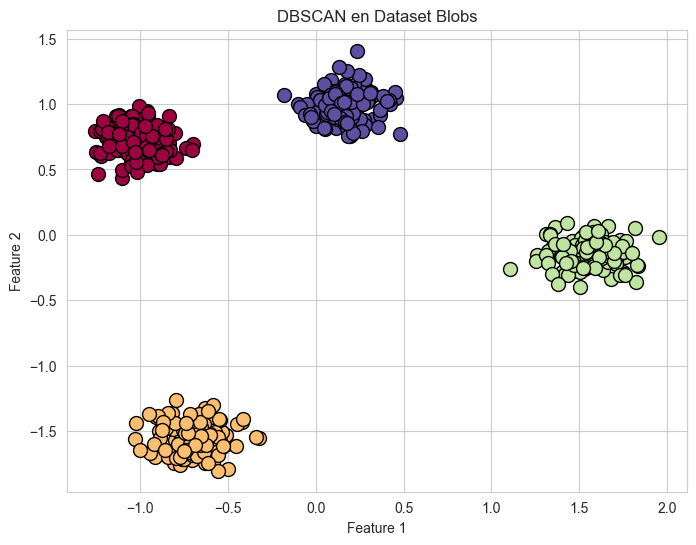

Silhouette Score (Blobs): 0.860
Número de clústeres encontrados: 4


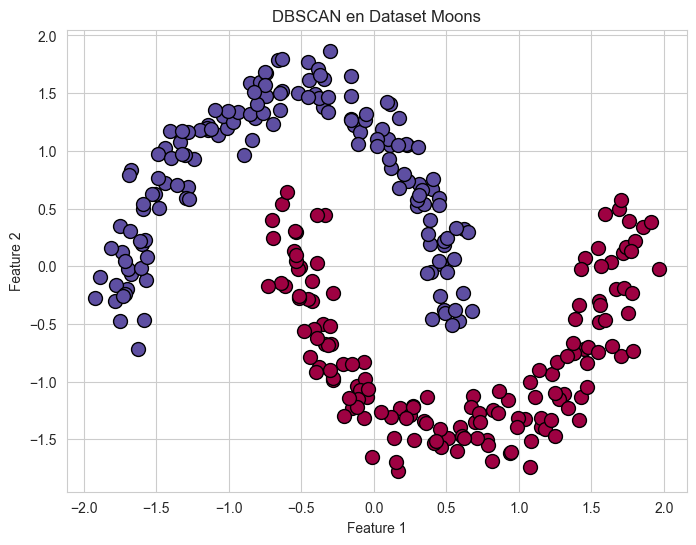

Silhouette Score (Moons): 0.380
Número de clústeres encontrados: 2


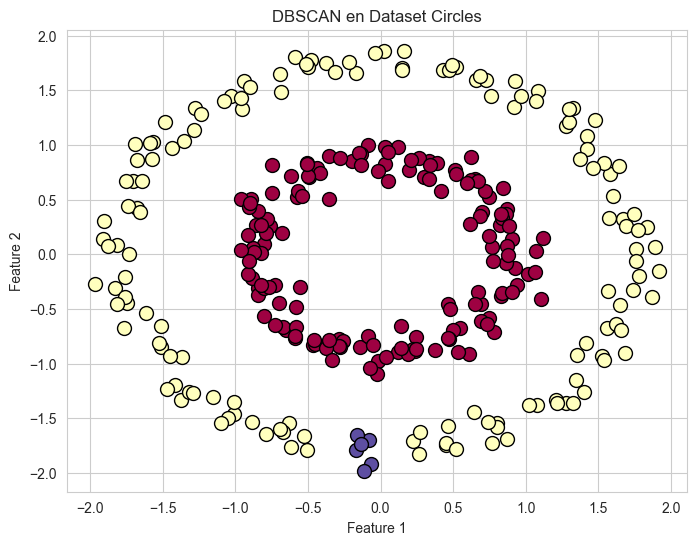

Silhouette Score (Circles): 0.004
Número de clústeres encontrados: 3


In [3]:
print("--- Aplicando DBSCAN a los datasets ---")

# DBSCAN en Blobs
# eps=0.5 es una suposición razonable para datos escalados
dbscan_blobs = DBSCAN(eps=0.5, min_samples=5)
labels_blobs = dbscan_blobs.fit_predict(X_blobs)
plot_clusters(X_blobs, labels_blobs, 'DBSCAN en Dataset Blobs')
print(f"Silhouette Score (Blobs): {silhouette_score(X_blobs, labels_blobs):.3f}")
print(f"Número de clústeres encontrados: {len(set(labels_blobs)) - (1 if -1 in labels_blobs else 0)}")

# DBSCAN en Moons
dbscan_moons = DBSCAN(eps=0.3, min_samples=5)
labels_moons = dbscan_moons.fit_predict(X_moons)
plot_clusters(X_moons, labels_moons, 'DBSCAN en Dataset Moons')
print(f"Silhouette Score (Moons): {silhouette_score(X_moons, labels_moons):.3f}")
print(f"Número de clústeres encontrados: {len(set(labels_moons)) - (1 if -1 in labels_moons else 0)}")

# DBSCAN en Circles
dbscan_circles = DBSCAN(eps=0.3, min_samples=5)
labels_circles = dbscan_circles.fit_predict(X_circles)
plot_clusters(X_circles, labels_circles, 'DBSCAN en Dataset Circles')
print(f"Silhouette Score (Circles): {silhouette_score(X_circles, labels_circles):.3f}")
print(f"Número de clústeres encontrados: {len(set(labels_circles)) - (1 if -1 in labels_circles else 0)}")

**Análisis de Resultados:**

- **Blobs**: Funciona perfectamente. Encuentra los 4 clústeres automáticamente.
- **Moons**: ¡Éxito total! DBSCAN es capaz de seguir la densidad de los puntos y captura perfectamente la estructura de las dos lunas. El Silhouette Score es mucho más bajo aquí porque la métrica en sí misma favorece clústeres convexos, ¡un buen ejemplo de que las métricas no siempre cuentan toda la historia!
- **Circles**: ¡Otro éxito! Encuentra los dos círculos concéntricos sin ningún problema.

### 4.3 Ventajas y Desventajas de DBSCAN <a id='4.3-ventajas-dbscan'></a>

**Ventajas:**

✅ **No necesita saber `k` de antemano:** DBSCAN no te obliga a decidir cuántos clústeres hay antes de empezar. El propio algoritmo detecta automáticamente cuántos grupos densos existen en los datos, según los parámetros elegidos.

✅ **Puede encontrar clústeres de formas arbitrarias:** A diferencia de K-Means, que solo detecta grupos "redondos" o esféricos, DBSCAN puede identificar clústeres de cualquier forma: alargados, curvos, con huecos, etc. Esto lo hace ideal para datos con estructuras complejas.

✅ **Robusto a outliers:** Los puntos que no pertenecen a ningún grupo denso (ruido o valores atípicos) se detectan y etiquetan automáticamente como "ruido" (`-1`). Así, DBSCAN no se ve afectado por estos puntos y no los fuerza a entrar en ningún clúster.

**Desventajas:**

❌ **Sensible a los hiperparámetros `eps` y `min_samples`:** Elegir bien estos valores es fundamental. Si `eps` es muy pequeño, casi todos los puntos serán ruido; si es muy grande, todos los puntos pueden acabar en un solo clúster. `min_samples` también afecta mucho al resultado. Para ayudar, se suele usar la [curva k-distance](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#dbscan), que muestra la distancia al vecino más cercano para cada punto y ayuda a elegir un buen `eps`.

❌ **No funciona bien con clústeres de densidades muy diferentes:** Si en tus datos hay grupos muy densos y otros muy dispersos, un solo valor de `eps` no servirá para ambos: o bien los grupos dispersos se rompen en trozos, o los densos se fusionan con el ruido.

❌ **Problemas en alta dimensión (maldición de la dimensionalidad):** Cuando los datos tienen muchas variables, la noción de "vecino" pierde sentido porque todos los puntos están lejos entre sí. En estos casos, DBSCAN puede tener dificultades para encontrar clústeres útiles.

In [ ]:
# Ejemplo: Curva k-distance para elegir eps en DBSCAN (usando Blobs)
from sklearn.neighbors import NearestNeighbors

X = X_blobs  # Puedes cambiar por X_moons o X_circles
min_samples = 5  # Igual que el parámetro que usarás en DBSCAN

# Calculamos la distancia al 5º vecino más cercano para cada punto
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Tomamos la distancia al último vecino (el más lejano de los 5 más cercanos)
k_distances = distances[:, -1]
k_distances = np.sort(k_distances)

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.ylabel(f"Distancia al {min_samples}º vecino más cercano")
plt.xlabel("Puntos ordenados")
plt.title("Curva k-distance para estimar eps en DBSCAN")
plt.grid(True)
plt.show()

print("Busca el punto donde la curva sube bruscamente (el 'codo'): ese valor es un buen candidato para eps.")

---

## 📊 5. Comparativa de Algoritmos <a id='5-comparativa'></a>

| Característica | K-Means | Clustering Jerárquico | DBSCAN |
| :--- | :--- | :--- | :--- |
| **Forma de los Clústeres** | Esférica / Convexa | Flexible (depende del linkage) | Arbitraria |
| **Número de Clústeres (`k`)**| Debe ser especificado | No es necesario (se elige del dendrograma) | Determinado automáticamente |
| **Manejo de Ruido** | No (sensible a outliers) | No (sensible a outliers) | Sí (robusto a outliers) |
| **Escalabilidad** | Alta (lineal o casi lineal) | Baja (cuadrática o cúbica) | Media (típicamente O(n log n)) |
| **Parámetros Principales** | `n_clusters` | `n_clusters` o `distance_threshold`, `linkage` | `eps`, `min_samples` |
| **Casos de Uso Ideales** | Propósitos generales, clústeres bien separados | Análisis exploratorio, taxonomías (biología) | Detección de anomalías, datos espaciales |

---

## 🏋️ 6. Ejercicios Prácticos <a id='6-ejercicios'></a>

1.  **Explorando `linkage`**: Vuelve a ejecutar el Clustering Jerárquico en el dataset `Moons`, pero esta vez prueba con `linkage='complete'` y `linkage='single'`. ¿Cambian los resultados? ¿Cuál funciona mejor?
2.  **Afinando DBSCAN**: En el dataset `Blobs`, DBSCAN funcionó bien. Intenta cambiar el valor de `eps`. ¿Qué pasa si usas un `eps` muy pequeño (ej. 0.1)? ¿Y uno muy grande (ej. 1.5)?
3.  **Caso Real - Iris**: Carga el dataset `iris` de Scikit-Learn. Aplica los tres algoritmos (K-Means, Jerárquico y DBSCAN). Para K-Means y Jerárquico, usa `k=3`. Para DBSCAN, tendrás que experimentar con `eps`. Compara los resultados con las etiquetas reales (`iris.target`). ¿Cuál funciona mejor?

---

## 📝 7. Resumen y Próximos Pasos <a id='7-resumen'></a>

### 🎉 ¡Has dominado las herramientas fundamentales del clustering!

#### ✅ Lo que has aprendido:

1. **K-Means**
   - **Ideal para**: Clústeres esféricos y bien separados.
   - **Fortaleza**: Rápido y escalable.
   - **Debilidad**: Falla con formas complejas y necesita saber `k`.

2. **Clustering Jerárquico**
   - **Ideal para**: Cuando la jerarquía de relaciones es importante.
   - **Fortaleza**: El dendrograma ofrece una gran visualización.
   - **Debilidad**: No escala bien a grandes datasets.

3. **DBSCAN**
   - **Ideal para**: Clústeres de formas arbitrarias y detección de ruido.
   - **Fortaleza**: No necesita saber `k` y es robusto a outliers.
   - **Debilidad**: Sensible a los parámetros `eps` y `min_samples`.

---

### 🚀 Próximo Módulo: Reducción de Dimensionalidad

Hemos explorado a fondo la primera gran tarea del aprendizaje no supervisado: el clustering. Ahora, nos moveremos a la segunda: la **reducción de dimensionalidad**.

En el próximo módulo, aprenderás técnicas para:

- **Simplificar** tus datos, reduciendo el número de características.
- **Visualizar** datasets de alta dimensión en 2D o 3D.
- **Mejorar el rendimiento** de otros algoritmos de Machine Learning.

**Has aprendido a encontrar grupos. Ahora, ¡vamos a aprender a ver el bosque en lugar de los árboles, simplificando la complejidad de tus datos!**